Imports

In [184]:
from pathlib import Path
import pandas as pd

## Let's see how the data looks like

In [185]:
fr_dir = Path(r"C:\Users\Utilisateur\data_analysis\metadata\fr")

def display_dataset(filename):
    file_path = next(fr_dir.rglob(filename), None)

    if file_path:
        df = pd.read_csv(file_path, sep="\t")
        print(df.columns)
        print("\n----- Column types: -----")
        for col in df.columns:
            print(f"{col}: {df[col].dtype}")
        print('-------------------------')
        print("Shape:", df.shape)
        print(df.head())
    else:
        print("clip_durations.tsv not found in the French metadata")

In [186]:
display_dataset("clip_durations.tsv")

Index(['clip', 'duration[ms]'], dtype='object')

----- Column types: -----
clip: object
duration[ms]: int64
-------------------------
Shape: (779271, 2)
                           clip  duration[ms]
0  common_voice_fr_17745229.mp3          1704
1  common_voice_fr_17317685.mp3          5904
2  common_voice_fr_19858224.mp3          2904
3  common_voice_fr_21569916.mp3          9456
4  common_voice_fr_27036600.mp3          6300


In [187]:
display_dataset("train.tsv")

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_20908\1818992672.py:7: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep="\t")


Index(['client_id', 'path', 'sentence', 'up_votes', 'down_votes', 'age',
       'gender', 'accents', 'variant', 'locale', 'segment'],
      dtype='object')

----- Column types: -----
client_id: object
path: object
sentence: object
up_votes: int64
down_votes: int64
age: object
gender: object
accents: object
variant: float64
locale: object
segment: float64
-------------------------
Shape: (527554, 11)
                                           client_id   
0  8330f74b2b975108da367487637761e146aa588a9ba49b...  \
1  8330f74b2b975108da367487637761e146aa588a9ba49b...   
2  8330f74b2b975108da367487637761e146aa588a9ba49b...   
3  8330f74b2b975108da367487637761e146aa588a9ba49b...   
4  8330f74b2b975108da367487637761e146aa588a9ba49b...   

                           path   
0  common_voice_fr_23936103.mp3  \
1  common_voice_fr_23936104.mp3   
2  common_voice_fr_23936106.mp3   
3  common_voice_fr_23936107.mp3   
4  common_voice_fr_23936108.mp3   

                                            sente

## Let's explore all the data


In [188]:
files_duration = root_directory.glob('**/clip_durations.tsv')
files_train = root_directory.glob('**/train.tsv')
files_test = root_directory.glob('**/test.tsv')
files_dev = root_directory.glob('**/dev.tsv')

I merge the train, test and dev sets for accurate statistics


In [189]:
def fill_nan(df: pd.DataFrame, column_name: str, value) -> pd.DataFrame:
    df[column_name].fillna(value, inplace = True)
    return df

In [190]:
def get_language_dataset(splits: list[str], duration_filename: str, lang_dir: Path) -> tuple[pd.DataFrame, pd.DataFrame]:
    # get all split files
    dfs = [pd.read_csv(f, sep="\t") for split in splits for f in lang_dir.rglob(split) if f.is_file()]
    merged_df = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

    # get duration file
    dur_files = list(lang_dir.rglob(duration_filename))
    df_duration = pd.read_csv(dur_files[0], sep="\t") if dur_files else pd.DataFrame()

    return merged_df, df_duration

In [191]:
language2dataframe = dict()
language2duration = dict()
for lang_dir in root_directory.iterdir():
    splits_to_unify = ["train.tsv", "dev.tsv", "test.tsv"]
    merged_df, df_duration = get_language_dataset(splits=splits_to_unify, duration_filename="clip_durations.tsv", lang_dir=lang_dir)

    # Let's take care of the NaN values
    merged_df = fill_nan(df=merged_df, column_name="gender", value="unknown")
    merged_df = fill_nan(df=merged_df, column_name="age", value="unknown")
    merged_df = fill_nan(df=merged_df, column_name="accents", value="unknown")
    merged_df = fill_nan(df=merged_df, column_name="variant", value="unknown")
    merged_df = fill_nan(df=merged_df, column_name="segment", value="unknown")

    # we don't want content where there is no proof someone spoke
    merged_df = merged_df.dropna(subset=["sentence"])
    language2dataframe[lang_dir.name] = merged_df
    language2duration[lang_dir.name] = df_duration

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_20908\3994447727.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(f, sep="\t") for split in splits for f in lang_dir.rglob(split) if f.is_file()]


In [192]:
assert all(df.shape != (0, 0) for df in language2dataframe.values()), \
       "Some dataframe in language2dataframe is empty (0,0)"
assert all(df.shape != (0, 0) for df in language2duration.values()), \
       "Some dataframe in language2duration is empty (0,0)"
assert len(language2dataframe) == len(language2duration) , \
       "Your dictionaries don't contain the same amount of languages"
assert  all(df.isnull().values.any() == False for df in language2duration.values()), \
        "Some dataframe(s) in language2duration contain(s) NaN values"
assert  all(df.isnull().values.any() == False for df in language2dataframe.values()), \
        "Some dataframe(s) in language2dataframe contain(s) NaN values"

Total recording duration and total number of different speakers per language:

In [193]:
def get_duration_and_num_speakers(duration_df: pd.DataFrame, lang_df: pd.DataFrame) -> list:
    """
    Collects the total recording duration and total number of different speakers for a given language
    """
    return [
        duration_df["clip"].iloc[0].split("_")[2],                    # language code
        duration_df["duration[ms]"].sum() / 1000 / 60 / 60,           # total hours
        lang_df["client_id"].nunique()                                # number of speakers
    ]

Statistics on languages per gender

In [194]:
def get_language_gender_durations(lang: str, duration_df: pd.DataFrame, lang_df: pd.DataFrame) -> list[dict]:
    """
    For a given language, collect by gender the total hours, number of speakers,
    avg_recs_per_speaker, median_recs_per_speaker, min_recs_per_speaker, max_recs_per_speaker
    """
    records = []
    # Merge to get durations
    df = lang_df.merge(duration_df, left_on="path", right_on="clip", how="left")
    df["gender"] = df["gender"].fillna("unknown")

    # Group by gender and aggregate stats
    for gender, group in df.groupby("gender"):
        recs_per_speaker = group.groupby("client_id").size()
        records.append({
            "language": lang,
            "gender": gender,
            "total_hours": group["duration[ms]"].sum() / 3_600_000,
            "n_speakers": group["client_id"].nunique(),
            "avg_recs_per_speaker": recs_per_speaker.mean(),
            "median_recs_per_speaker": recs_per_speaker.median(),
            "min_recs_per_speaker": recs_per_speaker.min(),
            "max_recs_per_speaker": recs_per_speaker.max()
        })
    return records

Person with the highest proportion of recordings by a person in the largest age bracket considered

In [203]:
def best_speaker_in_top_age(lang: str, df: pd.DataFrame) -> dict | None:
    """
    Find the person that speaks the biggest amount of times in the bigest age category throughout all languages
    :return:
    """
    df = df[df["age"].notna() & (df["age"] != "unknown")]
    if df.empty:
        return None

    top_age = df["age"].mode()[0]
    speaker_counts = df.loc[df["age"] == top_age, "client_id"].value_counts()
    if speaker_counts.empty:
        return None

    return {
        "language": lang,
        "age_bracket": top_age,
        "speaker_id": speaker_counts.index[0],
        "n_recs": speaker_counts.iloc[0],
    }

In [153]:
duration_and_num_speakers_ds = []
language_gender_durations_ds = []
best_result = None

for (lang, lang_df) in language2dataframe.items():
    duration_df = language2duration[lang]

    duration_and_num_speakers_ds.append(get_duration_and_num_speakers(duration_df, lang_df))

    language_gender_durations_ds.extend(get_language_gender_durations(lang, duration_df, lang_df))

    result = best_speaker_in_top_age(lang, lang_df)
    if result and (best_result is None or result["n_recs"] > best_result["n_recs"]):
        best_result = result



duration_and_num_speakers_df = pd.DataFrame(duration_and_num_speakers_ds, columns=["language", "total_hours", "n_speakers"])
language_gender_durations_df = pd.DataFrame(language_gender_durations_ds)


In [125]:
duration_and_num_speakers_df

,language,total_hours,n_speakers
0,ar,153.785855,1042
1,de,1387.409188,15580
2,en,3346.473639,54507
3,es,2187.036015,14127
4,fr,1084.054543,15378
5,id,63.761663,362
6,it,382.979383,6688
7,ja,225.920959,1426
8,lg,558.867518,591
9,ru,259.122860,2573


In [181]:
language_gender_durations_df.head()

,language,gender,total_hours,n_speakers,avg_recs_per_speaker,median_recs_per_speaker,min_recs_per_speaker,max_recs_per_speaker
0,ar,female,12.715280,110,97.072727,28.0,1,1286
1,ar,male,14.031102,330,35.042424,9.0,1,1174
2,ar,other,0.041560,8,4.875000,3.0,1,19
3,ar,unknown,30.907559,695,38.792806,4.0,1,2517
4,de,female,71.547012,622,72.205788,15.0,1,3068


In [205]:
print("Language with person having the most recordings in its largest age bracket:")
print(best_result)

Language with person having the most recordings in its largest age bracket:
{'language': 'de', 'age_bracket': 'fourties', 'speaker_id': '372293e65cdab88771e028a4351651ab2eff64438ddafc211e089247dcdccca350153465eb5409ce708081d9ad384af45d1dc57bbe030ae1a2c0edd561322fb8', 'n_recs': 41852}


# ~~~~~~~~~~~~~~~~~~~~~~

### Question 4
Determine the number of different genders considered in the corpus. What is the percentage
of recordings for which no gender information is available ? Plot the gender distribution
(including cases where gender information is not available). Do the same for ages.

In [8]:
dfs_duration_and_gender[0]['gender'].unique()

array(['male', nan, 'female', 'other'], dtype=object)

In [9]:


def get_info(info):
    dfs_duration_and_gender[2][info].fillna('Unknown', inplace=True)
    info2count = {information: [] for information in dfs_duration_and_gender[2][info].unique()}
    print(info2count.keys())
    for i,duration_and_gender_df in enumerate(dfs_duration_and_gender):
        duration_and_gender_df[info].fillna('Unknown', inplace=True)
        for info_detail in duration_and_gender_df[info].unique():
            info_count = len(duration_and_gender_df[duration_and_gender_df[info] == info_detail])
            info2count[info_detail].append(info_count)
        for values in info2count.values():
            if len(values) < i+1:
                values.append(0)
    return info2count

info2count = get_info('gender')
print(info2count)

dict_keys(['Unknown', 'male', 'female', 'other'])


{'Unknown': [4187, 14476, 13945, 12691, 14012, 1381, 12700, 2159, 2789, 6145, 5679, 3004, 6403, 8898], 'male': [4615, 1375, 1994, 2276, 1623, 1757, 1995, 1956, 5166, 2881, 2953, 3408, 3661, 1398], 'female': [1633, 278, 417, 772, 463, 479, 423, 821, 4077, 1161, 3389, 1816, 693, 302], 'other': [39, 38, 30, 57, 34, 21, 9, 42, 0, 9, 0, 0, 123, 27]}


In [5]:
dico = {'Unknown': [4187, 14476, 13945, 12691, 14012, 1381, 12700, 2159, 2789, 6145, 5679, 3004, 6403, 8898], 'male': [4615, 1375, 1994, 2276, 1623, 1757, 1995, 1956, 5166, 2881, 2953, 3408, 3661, 1398], 'female': [1633, 278, 417, 772, 463, 479, 423, 821, 4077, 1161, 3389, 1816, 693, 302], 'other': [39, 38, 30, 57, 34, 21, 9, 42, 0, 9, 0, 0, 123, 27]}
big_list = []
for values in dico.values(): 
    big_list.extend(values)
print(f"Proportion of Unknown genders: {sum(dico['Unknown'])/sum(big_list)}")

Proportion of Unknown genders: 0.6667629702483403


Text(0.5, 1.0, 'Count of Info by Language')

<Figure size 5000x1200 with 0 Axes>

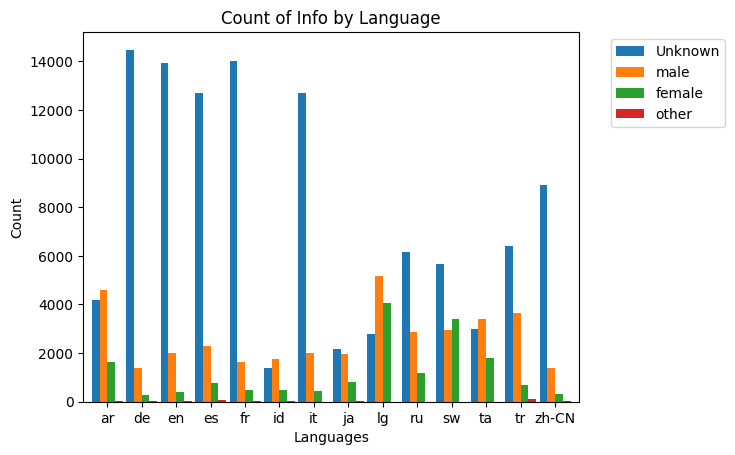

In [10]:
import matplotlib.pyplot as plt

df = pd.DataFrame(info2count, index=languages)
plt.figure(figsize=(50, 12))
ax = df.plot.bar(rot=0, width=0.9)
#ax.set_yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Languages')
plt.ylabel('Count')
plt.title('Count of Info by Language')

### Question 5
Find out for each language and each gender the 7 speakers who produced the most recordings.

In [11]:
# Question 5: a bit ambiguous. I have decided to find the 7 best speakers for each gender and
# the seven best speakers for each language 
dfs_topSeven_speakers_per_gender = []
dfs_topSeven_speakers_per_language = []
for language, duration_and_gender_df in zip(languages,dfs_duration_and_gender):
    
    #interpretation 1
    topSeven_speakers_per_gender = duration_and_gender_df.groupby('gender').apply(lambda x: x.nlargest(7, 'duration'))[['client_id', 'gender', 'duration']]\
                .assign(language=language)
    # interpretation 2
    top_speakers = duration_and_gender_df.groupby(['client_id', 'gender']).agg({'duration': 'sum'}).nlargest(7, 'duration').reset_index()\
                .assign(language=language)

    dfs_topSeven_speakers_per_gender.append(topSeven_speakers_per_gender)
    dfs_topSeven_speakers_per_language.append(top_speakers)

topSeven_gender = pd.concat(dfs_topSeven_speakers_per_gender, ignore_index=True)

topSeven_language = pd.concat(dfs_topSeven_speakers_per_language, ignore_index=True)
topSeven_language.head(35)

,client_id,gender,duration,language
0,f4e2edd6806081659b58961d645478d52b35abf7f3b43d...,male,581868,ar
1,fac0e0620a2a168767fac7877778ba19086a86e38d25ae...,male,497772,ar
2,76f8de6509ec32e00464e3d5aba119f5e8afaeb5ecfc6f...,male,494340,ar
3,feccb3f951cc55f353b9defb9c591fd2a2d9574473dcc3...,male,482508,ar
4,1ab9e28de0d3cbee2f82ad8583f8ee566553887f0899bf...,male,480060,ar
5,521b0cd4ed0f53758eae8a9f8c38c951ab3b2552782335...,male,442800,ar
6,df7c9bc12f08dd6792c028a5e0fd8e02e82ebd5d306d20...,female,435348,ar
7,0bdca80d3682d1981625e65d89f7f70680309dfb1a30f0...,Unknown,46692,de
8,06e281154ce7354d5a79696e2c81037e1bdd34938cb4a9...,Unknown,46404,de
9,4bb4eda0641be17dbbf9dca9edfd8791d761cf369819f6...,Unknown,46008,de


In [12]:
topSeven_gender.head(30)

,client_id,gender,duration,language
0,1be0c60040d7ca5fc75abe8a7dadcf9a1a164fa51ad61f...,Unknown,10404,ar
1,2a213bd30d42fd16bb297ffe8f6a15ca4acb1dd0ebcb89...,Unknown,10368,ar
2,c8cff7d932453f0d7f28b9839cae955fda7aee00336865...,Unknown,10368,ar
3,2f9855b3d6b785e1c874532cbe4092c9f4af7bf77d17f5...,Unknown,10368,ar
4,fc884ed3e829b049ad2a053ffa619ac907c32cbaf06861...,Unknown,10188,ar
5,69e0d6e2eae73b4769550a0c5fcf2ef930f7d26e707292...,Unknown,10116,ar
6,2a213bd30d42fd16bb297ffe8f6a15ca4acb1dd0ebcb89...,Unknown,10080,ar
7,13727dbeddbad8abcef97333b0109a321c8affad216ee6...,female,10440,ar
8,68258151fa260f539ee4ba5129286a35caba9121782c25...,female,10008,ar
9,68258151fa260f539ee4ba5129286a35caba9121782c25...,female,9936,ar


### Question 6
For each language, create a 1-hour test set and a training set as large as possible, ensuring
that speakers from the test set do not appear in the training set.

In [13]:
def create_test_train_sets(df, target_test_duration):
    df = df.sort_values('duration', ascending=False) # ranking to ensure a higher diversity of speakers
    speakers_test = []
    test_duration = 0
    id_test = []
    df = df.sample(frac=1, random_state=42)
    for index, row in df.iterrows():
        if test_duration <= target_test_duration:
            speakers_test.append(row['client_id']) 
            id_test.append(row['id'])
            test_duration += row['duration']
    df1_train = df[~df['client_id'].isin(speakers_test)] #train sets trop petits si on prend les client_id pas dans le test set
    df1_test = df[df['id'].isin(id_test)]

    return df1_train, df1_test

In [14]:
def make_duration_test(duration):
    duration = duration * 1000 #convert to ms
    dfs_train_test = []
    for language, duration_and_gender_df in zip(languages, dfs_duration_and_gender):
            print(language)

            df1_train, df1_test = create_test_train_sets(duration_and_gender_df, duration)

            df1_train.drop(columns=['duration'], inplace=True)
            df1_test.drop(columns=['duration'], inplace=True)

            print(f"Total duration in the training set: {(df1_train['duration'].sum())/1000} seconds")
            print(f"Total duration in the test set: {(df1_test['duration'].sum())/1000} seconds")
            dfs_train_test.append((df1_train, df1_test))
    return dfs_train_test

dfs_train_test_3600 = make_duration_test(3600)

ar
Total duration in the training set: 11058.097 seconds
Total duration in the test set: 3602.45 seconds
de
Total duration in the training set: 85449.966 seconds
Total duration in the test set: 3601.155 seconds
en
Total duration in the training set: 91512.28 seconds
Total duration in the test set: 3606.483 seconds
es
Total duration in the training set: 86474.95 seconds
Total duration in the test set: 3606.594 seconds
fr
Total duration in the training set: 81524.328 seconds
Total duration in the test set: 3605.602 seconds
id
Total duration in the training set: 1199.868 seconds
Total duration in the test set: 3601.425 seconds
it
Total duration in the training set: 80284.494 seconds
Total duration in the test set: 3604.716 seconds
ja
Total duration in the training set: 8595.732 seconds
Total duration in the test set: 3604.14 seconds
lg
Total duration in the training set: 7508.919 seconds
Total duration in the test set: 3600.96 seconds
ru
Total duration in the training set: 37092.009 secon

### Question 7
How many languages have more female than male recordings ?

In [15]:
# Question 7

In [33]:
import pandas as pd
pivoted_df = results_df[(results_df['gender'] == 'female') | (results_df['gender'] == 'male')]\
    .pivot_table(index='language', columns='gender', values='duration', aggfunc='sum')

mostly_female = pivoted_df[pivoted_df['female'] > pivoted_df['male']]
mostly_female.head(5)

gender,female,male
language,,
sw,19503252,16535484


### Question 8
Which language has the most unbalanced gender distribution ?

In [42]:
pivoted_df['absolute_difference'] = abs(pivoted_df['female'] - pivoted_df['male'])

# Find the language with the highest absolute difference
most_unbalanced_language = pivoted_df['absolute_difference'].idxmax()

print(f"Language with the most unbalanced gender distribution: {most_unbalanced_language}")

Language with the most unbalanced gender distribution: ar


### Question 9
For each language, create a train set containing 1 hour of recordings and a 10-minute test
set so that : 
i) train and test are gender-balanced 
ii) the train and test speakers are different

In [19]:
def create_gendered_test_train_sets(df_gender, speakers, records, target_balanced_duration):
    test_duration = 0
    train_duration = 0
    for index, row in df_gender.iterrows():
        if test_duration <= target_balanced_duration:
            speakers.append(row['client_id'])
            records.append(row['id'])
            test_duration += row['duration']

    return df_gender[df_gender['id'].isin(records)] #we want precise recording to be in the test set

In [20]:
def create_test_train_sets(df, target_train_duration, target_test_duration):
    
    speakers_test = []
    records_test = []

    speakers_train = []
    records_train = []

    df = df.sort_values('duration', ascending=False) # ranking to ensure a higher diversity of speakers
    df = df.sample(frac=1, random_state=42)
    
    male_df = df[df['gender'] == 'male']
    female_df = df[df['gender'] == 'female']
    other_df = df[df['gender'] == 'other']
    target_balanced_train_duration = (target_train_duration*1000)/3  #convert to ms
    target_balanced_test_duration = (target_test_duration*1000)/3  #convert to ms

    liste_dfs = [male_df, female_df, other_df]
    dfs = []
    for df_gender_test in liste_dfs: 
        
        df_test = create_gendered_test_train_sets(df_gender_test, speakers_test, records_test, target_balanced_test_duration)
        # we want different speakers in the train and test sets
        df_gender_train = df_gender_test[~df_gender_test['client_id'].isin(speakers_test)]
        df_train = create_gendered_test_train_sets(df_gender_train, speakers_train, records_train, target_balanced_train_duration)
        
        dfs.append((df_train, df_test))

   

    return pd.concat([dfs[i][0] for i in range(len(dfs))]), pd.concat([dfs[i][1] for i in range(len(dfs))])

In [22]:
def make_duration_test(duration_train, duration_test):
    dfs_train_test = []
    for language, duration_and_gender_df in zip(languages, dfs_duration_and_gender):
        print(language)
        df1_train, df1_test = create_test_train_sets(duration_and_gender_df, duration_train, duration_test)
  
        df1_train.drop(columns=['duration'], inplace=True)
        df1_test.drop(columns=['duration'], inplace=True)

        print(f"Total duration in the training set: {(df1_train['duration'].sum())/1000} seconds")
        print(f"Total duration in the test set: {(df1_test['duration'].sum())/1000} seconds")
        dfs_train_test.append((df1_train, df1_test))
    return dfs_train_test

dfs_train_3600_test_600 = make_duration_test(3600, 600)

ar


Total duration in the training set: 2406.552 seconds
Total duration in the test set: 555.732 seconds
de
Total duration in the training set: 2250.474 seconds
Total duration in the test set: 605.878 seconds
en
Total duration in the training set: 2406.67 seconds
Total duration in the test set: 580.044 seconds
es
Total duration in the training set: 2481.048 seconds
Total duration in the test set: 604.884 seconds
fr
Total duration in the training set: 2402.526 seconds
Total duration in the test set: 579.888 seconds
id
Total duration in the training set: 1461.924 seconds
Total duration in the test set: 508.38 seconds
it
Total duration in the training set: 2406.456 seconds
Total duration in the test set: 465.54 seconds
ja
Total duration in the training set: 2407.116 seconds
Total duration in the test set: 611.904 seconds
lg
Total duration in the training set: 2406.54 seconds
Total duration in the test set: 407.76 seconds
ru
Total duration in the training set: 2407.152 seconds
Total duration i

### Question 10
Plot, for each language, a box plot representing the distribution of the number of words
per sentence.

ValueError: Dimensions of labels and X must be compatible

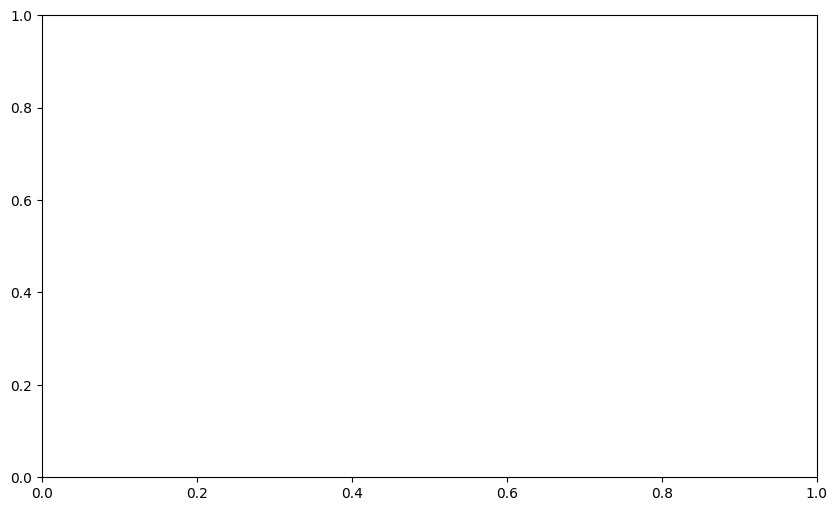

In [24]:
# Sample data for three dataframes
dataframes = []

# Populate dataframes (Example data for demonstration purposes)
dataframes = dfs_duration_and_gender

# Using Sacremoses for tokenization
mt = MosesTokenizer()

# Create a list to store the number of words for each dataframe
num_words_list = []

for language, df in zip(languages, dataframes):
    if language != 'sw':
        df['num_words'] = df['sentence'].apply(lambda x: len(mt.tokenize(x, return_str=True).split()))
        num_words_list.append(df['num_words'])

# Creating a box plot for all dataframes
plt.figure(figsize=(10, 6))
plt.boxplot(num_words_list, labels=['Dataframe 1', 'Dataframe 2', 'Dataframe 3'])
plt.title('Distribution of the Number of Words per Sentence for Multiple Dataframes')
plt.ylabel('Number of Words')
plt.show()

### Question 11
For each language, find the 17 most frequent words after having removed stop words

In [ ]:
import pandas as pd
from nltk.corpus import stopwords
from collections import Counter
from polyglot.text import Text
import matplotlib.pyplot as plt



# Using Polyglot for tokenization
df['num_words'] = df['sentence'].apply(lambda x: len(Text(x).words))

# Creating a box plot
plt.figure(figsize=(10, 6))
df.boxplot(column='num_words')
plt.title('Distribution of the Number of Words per Sentence')
plt.ylabel('Number of Words')
plt.show()
dfs = []
for language, df in zip(languages, dfs_duration_and_gender):

    print(language)
    df['tokenized_sentence'] = df['sentence'].apply(lambda x: mt.tokenize(x, return_str=True).split())

    # Removing stop words
    stop_words = set(stopwords.words(lang=language))
    df['filtered_sentence'] = df['tokenized_sentence'].apply(lambda x: [word for word in x if word.lower() not in stop_words])

    # Counting word frequency
    word_counts = Counter([word for sublist in df['filtered_sentence'] for word in sublist])

    # Finding the 17 most frequent words
    most_common_words = word_counts.most_common(17)

    # Create a DataFrame
    result_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

    # Transpose the DataFrame
    result_df = result_df.set_index('Word').T

    # Add 'language' as a column
    result_df['language'] = language

    # Reorder the columns
    result_df = result_df[['language'] + list(result_df.columns[:-1])]

    dfs.append(result_df)

# Concatenate all DataFrames into one
concatenated_df = pd.concat(dfs, ignore_index=True)
concatenated_df

ar


LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - 'C:\\Users\\Utilisateur/nltk_data'
    - 'c:\\Users\\Utilisateur\\AppData\\Local\\Programs\\Python\\Python311\\nltk_data'
    - 'c:\\Users\\Utilisateur\\AppData\\Local\\Programs\\Python\\Python311\\share\\nltk_data'
    - 'c:\\Users\\Utilisateur\\AppData\\Local\\Programs\\Python\\Python311\\lib\\nltk_data'
    - 'C:\\Users\\Utilisateur\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [ ]:
        
from polyglot.text import Text
rows = []

for language, df in zip(languages, dfs_duration_and_gender):
    if language != 'sw':
        df['num_words'] = df['sentence'].apply(lambda x: len(Text(x).words))
        row = {'language': language, 'total_duration': df['duration'].sum(), 'num_words': df['num_words'].sum()}
        rows.append(row)

df_total = pd.DataFrame(rows, columns=['language', 'total_duration', 'num_words'])
df_total.head(15)

In [10]:
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Directory containing the text files
directory = "C://Users//Utilisateur//data_analysis//US_Inaugural_Addresses"

def get_text_and_title(file_path):
    file_name = os.path.basename(file_path)
    if file_name[0].isdigit():
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            title = os.path.basename(file_path).replace('.txt', '')
            return text, title

titles = []
texts = []

for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        file_path = os.path.join(directory, filename)
        result = get_text_and_title(file_path)
        if result is not None:
            text, title = result
            titles.append(title)
            texts.append(text)

vectorizer = TfidfVectorizer()
tfidf_vectors = vectorizer.fit_transform(texts)

data = tfidf_vectors.toarray()
df = pd.DataFrame(data, columns=vectorizer.get_feature_names_out())
df['Title'] = titles
df.set_index('Title', inplace=True)

df.head(30)

,000,03,04,05,100,120,125,13,14th,151,...,yours,yourself,yourselves,youth,youthful,zachary,zeal,zealous,zealously,zone
Title,,,,,,,,,,,,,,,,,,,,,
01_washington_1789,0.0,0.000000,0.009348,0.0,0.0,0.0,0.0,0.000000,0.024328,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
01_washington_1789_1,0.0,0.000000,0.009348,0.0,0.0,0.0,0.0,0.000000,0.024328,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
02_washington_1793,0.0,0.061981,0.063289,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
02_washington_1793_1,0.0,0.061981,0.063289,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
03_adams_john_1797,0.0,0.005722,0.005843,0.0,0.0,0.0,0.0,0.000000,0.000000,0.015208,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.009551,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48_carter_1977_1,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
49_reagan_1981,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.013931,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
49_reagan_1981_1,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.013931,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0


In [44]:
from sklearn.metrics.pairwise import cosine_similarity 

# Create a DataFrame to display the cosine similarity
df_cosine_similarities = pd.DataFrame(cosine_similarity(tfidf_vectors), columns=titles, index=titles)
df_cosine_similarities

,01_washington_1789,01_washington_1789_1,02_washington_1793,02_washington_1793_1,03_adams_john_1797,03_adams_john_1797_1,04_jefferson_1801,04_jefferson_1801_1,05_jefferson_1805,05_jefferson_1805_1,...,54_bush_george_w_2001,54_bush_george_w_2001_1,55_bush_george_w_2005,55_bush_george_w_2005_1,56_obama_2009,56_obama_2009_1,57_obama_2013,57_obama_2013_1,58_trump_2017,58_trump_2017_1
01_washington_1789,1.000000,1.000000,0.597062,0.597062,0.817582,0.817582,0.817908,0.817908,0.803900,0.803900,...,0.590933,0.590933,0.743777,0.743777,0.699812,0.699812,0.641855,0.641855,0.596988,0.596988
01_washington_1789_1,1.000000,1.000000,0.597062,0.597062,0.817582,0.817582,0.817908,0.817908,0.803900,0.803900,...,0.590933,0.590933,0.743777,0.743777,0.699812,0.699812,0.641855,0.641855,0.596988,0.596988
02_washington_1793,0.597062,0.597062,1.000000,1.000000,0.593332,0.593332,0.591654,0.591654,0.565175,0.565175,...,0.401395,0.401395,0.540844,0.540844,0.478006,0.478006,0.447054,0.447054,0.415717,0.415717
02_washington_1793_1,0.597062,0.597062,1.000000,1.000000,0.593332,0.593332,0.591654,0.591654,0.565175,0.565175,...,0.401395,0.401395,0.540844,0.540844,0.478006,0.478006,0.447054,0.447054,0.415717,0.415717
03_adams_john_1797,0.817582,0.817582,0.593332,0.593332,1.000000,1.000000,0.854324,0.854324,0.836523,0.836523,...,0.676502,0.676502,0.804377,0.804377,0.753091,0.753091,0.698363,0.698363,0.652866,0.652866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56_obama_2009_1,0.699812,0.699812,0.478006,0.478006,0.753091,0.753091,0.786003,0.786003,0.779176,0.779176,...,0.790820,0.790820,0.821775,0.821775,1.000000,1.000000,0.858517,0.858517,0.780710,0.780710
57_obama_2013,0.641855,0.641855,0.447054,0.447054,0.698363,0.698363,0.736842,0.736842,0.728434,0.728434,...,0.789071,0.789071,0.788056,0.788056,0.858517,0.858517,1.000000,1.000000,0.761730,0.761730
57_obama_2013_1,0.641855,0.641855,0.447054,0.447054,0.698363,0.698363,0.736842,0.736842,0.728434,0.728434,...,0.789071,0.789071,0.788056,0.788056,0.858517,0.858517,1.000000,1.000000,0.761730,0.761730
58_trump_2017,0.596988,0.596988,0.415717,0.415717,0.652866,0.652866,0.681274,0.681274,0.663117,0.663117,...,0.748228,0.748228,0.751264,0.751264,0.780710,0.780710,0.761730,0.761730,1.000000,1.000000


c:\Users\Utilisateur\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\Utilisateur\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


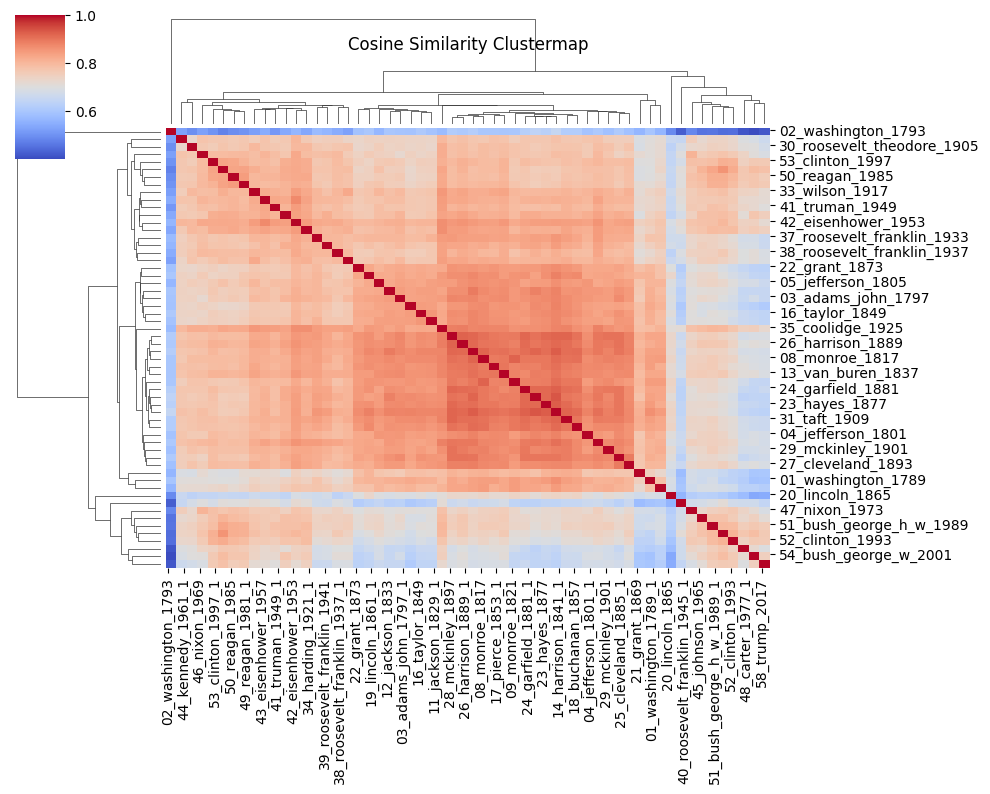

In [18]:
import seaborn as sns

# Create a clustermap
clustermap = sns.clustermap(df_cosine_similarities, cmap='coolwarm', figsize=(10, 8))
clustermap.ax_heatmap.set_title('Cosine Similarity Clustermap',pad=25, y=1.1)

plt.show()

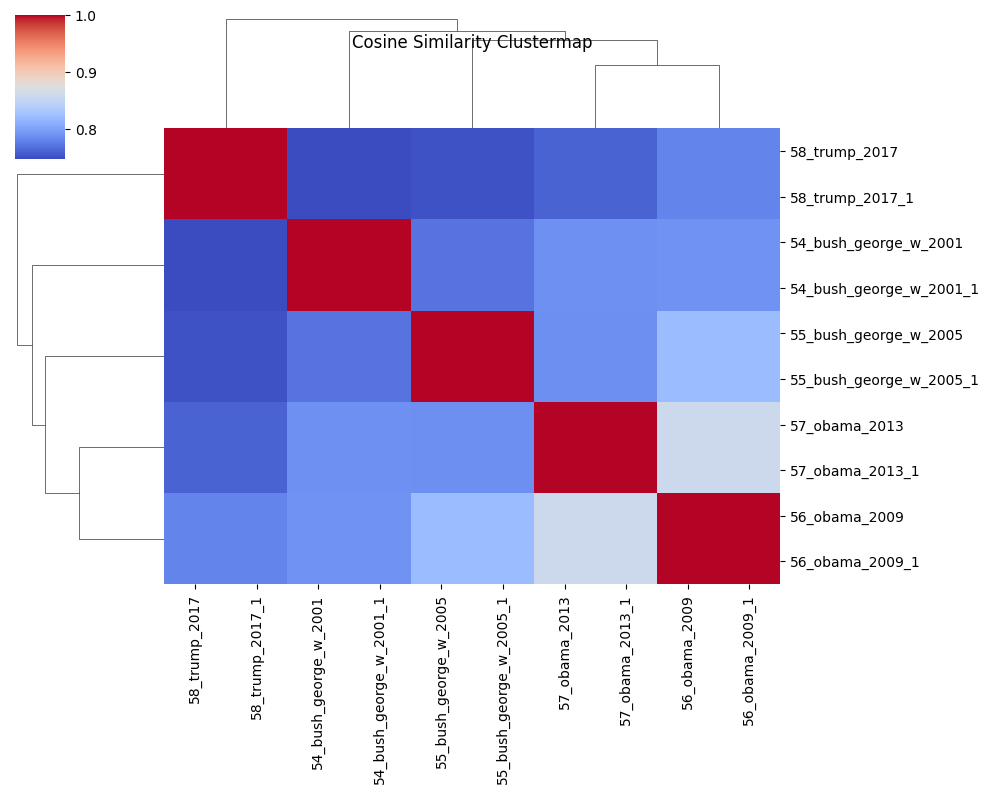

In [45]:
import seaborn as sns

# Create a clustermap
clustermap = sns.clustermap(df_cosine_similarities.tail(10)[df_cosine_similarities.columns[-10:]], cmap='coolwarm', figsize=(10, 8))
clustermap.ax_heatmap.set_title('Cosine Similarity Clustermap', pad=25, y=1.1)

plt.show()